# Feature importance analysis

In this notebook we analyse the importance of each SNP to the model using the [Integrated Gradients](https://arxiv.org/pdf/1703.01365.pdf) method. 

_Imports and configs_

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import explain_ensemble
# from diabnet.model import load
from diabnet.data import get_feature_names
from diabnet.ensemble import Ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates

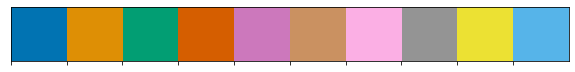

In [3]:
colors = sns.color_palette("colorblind")
sns.palplot(colors)
sns.set_style("whitegrid")
sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '-'})

_load trained ensemble model_

In [4]:
ensemble = Ensemble('../data/models/model-positive-13-adamw-lc5-2021-03-03')

../data/models/model-positive-13-adamw-lc5-2021-03-03


In [5]:
feat_names = get_feature_names("../data/datasets/visits_sp_unique_test_positivo_1000_random_0.csv", use_bmi=False, use_sex=True, use_parents_diagnosis=True)

In [6]:
# DEBUG:
feat_names[-20:]

['snp_1_28265165',
 'snp_7_62322704',
 'snp_6_57432511',
 'snp_19_5147864',
 'snp_9_1667961',
 'snp_7_142786651',
 'snp_9_68692515',
 'snp_12_53198338',
 'snp_6_37571581',
 'snp_20_52032232',
 'snp_20_52032233',
 'snp_20_26104019',
 'snp_20_50189624',
 'snp_1_143276644',
 'snp_16_9536673',
 'snp_20_25734788',
 'AGE',
 'sex',
 'mo_t2d',
 'fa_t2d']

In [7]:
# feature attribution using training dataset
e_train = explain_ensemble.ExplainModel(ensemble, feat_names, "../data/datasets/visits_sp_unique_train_positivo_1000_random_0.csv")

In [8]:
# feature attribution using test dataset
e_test = explain_ensemble.ExplainModel(ensemble, feat_names, "../data/datasets/visits_sp_unique_test_positivo_1000_random_0.csv")

In [9]:
def feat_importance(values, age, sex):
    imp = values.calc_attr(age, sex)
    # testa se o SNP tem valores 1 ou 2. caso não tenha, sua importancia não pode ser calculada
    s = {k: [np.mean(imp[k]), np.median(imp[k])] for k in imp if len(imp[k]) > 0} 
    df = pd.DataFrame.from_dict(s, orient='index')
    df.rename(columns={0:f'{sex}{age}_mean', 1:f'{sex}{age}_median'}, inplace=True)
    # df.sort_values(by=0, ascending=False).head(50)
    return df
    

# Feature Importance

Qual a importância dos SNPs independentemente de outras características (sexo, diagnóstico dos pais, idade*).
*Para torna independente da idade fixamos a idade em 50.

In [10]:
age = 50
sex = 'X' # 'X' significa qualquer sexo

Não há um consenso se a análise de importância das características (feature importance) deve ser feita com os dados de teste ou treinamento. Nós testamos os dois...

In [12]:
df_feat_imp_50_X_train = feat_importance(e_train, 50, 'X')

In [10]:
df_feat_imp_50_X_test = feat_importance(e_test, 50, 'X')

No entanto, no conjunto de teste 44 dos 1000 SNPs não possuem o gene base do alelo recessivo (valores 1 ou 2) e consequentemente, não conseguimos atribuir um valor de importância. E como notamos pelo boxplot abaixo, boa parte deles podem ser importantes.

44 SNPs não tem valores no conjunto de teste


<AxesSubplot:ylabel='X50_mean'>

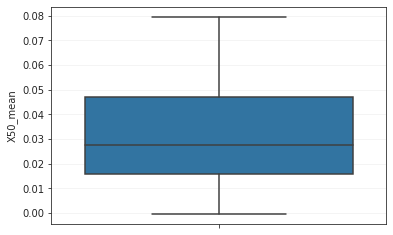

In [14]:
excluded = df_feat_imp_50_X_train[df_feat_imp_50_X_train.index.isin(df_feat_imp_50_X_test.index) == False]
print(f"{excluded.count()[0]} SNPs não tem valores no conjunto de teste")
sns.boxplot(y="X50_mean", data=excluded)

In [15]:
df_feat_imp_50_X = df_feat_imp_50_X_train.join(df_feat_imp_50_X_test, how='inner', lsuffix='_train', rsuffix='_test')
df_feat_imp_50_X['SNP'] = df_feat_imp_50_X.index
# parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
df_feat_imp_50_X = df_feat_imp_50_X.sort_values(by="X50_mean_train")
df_feat_imp_50_X # apenas 956 pq 44 dos SNPs não tem valores 1 ou 2 no conjunto de teste 

,X50_mean_train,X50_median_train,X50_mean_test,X50_median_test,SNP
snp_17_15464147,-0.059783,-0.029669,-0.055890,-0.025617,snp_17_15464147
snp_21_11058226,-0.031148,-0.021287,-0.031055,-0.021263,snp_21_11058226
snp_4_181784699,-0.026839,-0.016237,-0.028079,-0.016225,snp_4_181784699
snp_16_19717582,-0.026752,-0.018913,-0.024395,-0.017139,snp_16_19717582
snp_16_82889990,-0.023424,-0.013041,-0.019469,-0.010958,snp_16_82889990
...,...,...,...,...,...
snp_1_83758875,0.076975,0.067904,0.072400,0.071241,snp_1_83758875
snp_3_124845764,0.081818,0.058807,0.073538,0.050040,snp_3_124845764
snp_11_120855337,0.085279,0.081142,0.097226,0.100925,snp_11_120855337
snp_10_15653813,0.087386,0.088941,0.068368,0.044592,snp_10_15653813


Comparando a média e a mediana da importância calculada para os conjuntos de treinamento e teste podemos ver que há uma correlação significativa (como esperado). Logo, optaremos por realizar as análises subsequentes apenas com a importância calculada no conjunto de treinamento.

In [93]:
plt.figure(figsize=(12,6));
plt.subplot(121);
# plt.scatter(tmp.X50_mean_train.values, tmp.X50_mean_test.values);
sns.scatterplot(x="X50_mean_train", y="X50_mean_test", data=df_feat_imp_50_X)
plt.ylim(-0.12,0.12)
plt.xlim(-0.12,0.12)
plt.subplot(122);
# plt.scatter(tmp.X50_median_train.values, tmp.X50_median_test.values);
sns.scatterplot(x="X50_median_train", y="X50_median_test", data=df_feat_imp_50_X)
plt.ylim(-0.12,0.12)
plt.xlim(-0.12,0.12)
plt.figure(figsize=(12,4));
df_feat_imp_50_X.boxplot();

ValueError: Could not interpret value `X50_mean_train` for parameter `x`

<AxesSubplot:ylabel='X50_mean'>

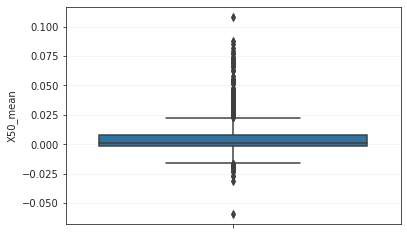

In [17]:
sns.boxplot(y="X50_mean", data=df_feat_imp_50_X_train)

In [18]:
df_feat_imp_50_X_train.describe()

,X50_mean,X50_median
count,1000.000000,1000.000000
mean,0.005969,0.003162
std,0.016351,0.012462
min,-0.059783,-0.029669
25%,-0.001740,-0.000629
50%,0.000792,0.000092
75%,0.008059,0.001804
max,0.108445,0.116756


In [19]:
df_feat_imp_50_X_train["chr"] = [int(s.split('_')[1]) for s in df_feat_imp_50_X_train.index]
df_feat_imp_50_X_train["pos"] = [float(s.split('_')[2]) for s in df_feat_imp_50_X_train.index]
df_feat_imp_50_X_train

,X50_mean,X50_median,chr,pos
snp_8_133462953,0.018099,0.001841,8,133462953.0
snp_2_91635413,0.009943,0.002771,2,91635413.0
snp_9_25963828,0.004374,0.003240,9,25963828.0
snp_1_17764169,0.001246,0.000241,1,17764169.0
snp_12_41767967,-0.001231,-0.000296,12,41767967.0
...,...,...,...,...
snp_20_26104019,0.002006,0.000534,20,26104019.0
snp_20_50189624,-0.007468,-0.005415,20,50189624.0
snp_1_143276644,-0.002042,-0.000564,1,143276644.0
snp_16_9536673,-0.003741,-0.000526,16,9536673.0


O gráfico da atribuição dos SNPs separado por cromossomo (abaixo) mostra que os chr 1 e 3 

<AxesSubplot:xlabel='chr', ylabel='X50_mean'>

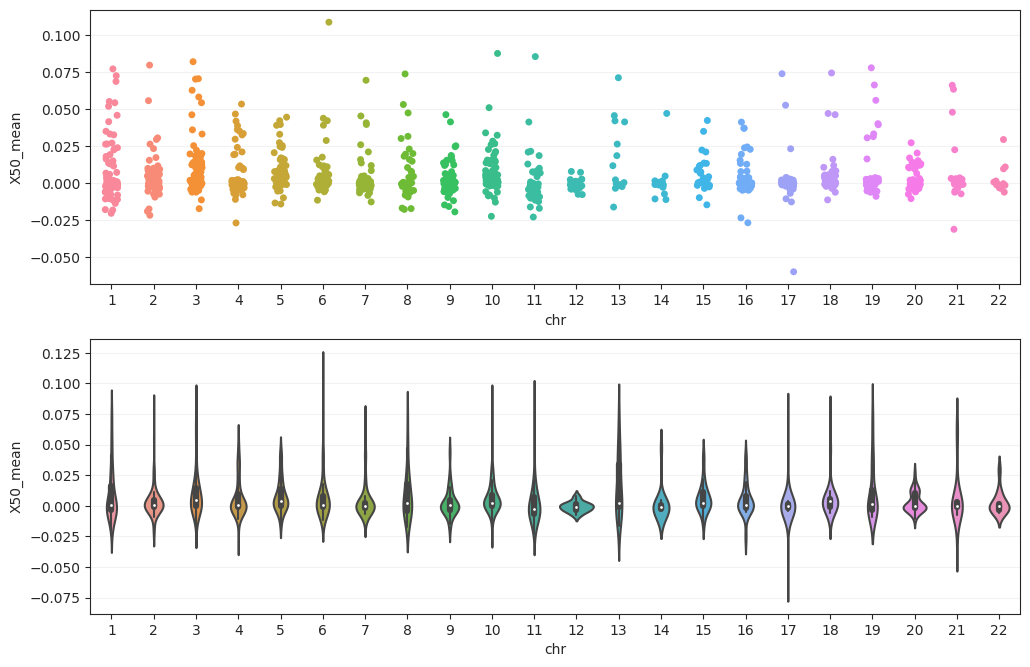

In [20]:
fig = plt.figure(figsize=(12,8), dpi=100)
plt.subplot(211)
sns.stripplot(x="chr", y="X50_mean", data=feat_imp_train, jitter=0.15)
plt.subplot(212)
sns.violinplot(x="chr", y="X50_mean", data=feat_imp_train, whis=np.inf)

In [ ]:
fig = plt.figure(figsize=(12,12), dpi=100)
plt.subplots_adjust(hspace=0.7, wspace=0.25)
for i in range(22):
    ax1=plt.subplot(8, 3, i+1)
    plt.title(f"chr: {i+1}")
    sns.scatterplot(x='pos', y="X50_mean", data=feat_imp_train[feat_imp_train["chr"]==i+1], hue="X50_mean", hue_norm=(-0.3,0.3), palette="RdBu_r", edgecolor="k")
    ax1.get_legend().remove()
    plt.ylim(-0.12,0.12)
    plt.ylabel("")
    plt.xlabel("")


In [22]:
selection = feat_imp_train[abs(feat_imp_train['X50_mean'])> 0.05]

In [23]:
# selection.sort_values(by='X50_mean').to_csv("feature_importance.csv")

In [24]:
selection.sort_values(by='X50_mean', ascending=False)

,X50_mean,X50_median,chr,pos
snp_6_121073528,0.108445,0.116756,6,121073528.0
snp_10_15653813,0.087386,0.088941,10,15653813.0
snp_11_120855337,0.085279,0.081142,11,120855337.0
snp_3_124845764,0.081818,0.058807,3,124845764.0
snp_2_98333598,0.079516,0.088930,2,98333598.0
snp_19_34109339,0.077705,0.081371,19,34109339.0
snp_1_83758875,0.076975,0.067904,1,83758875.0
snp_18_56742728,0.074233,0.070259,18,56742728.0
snp_17_15868329,0.073726,0.062141,17,15868329.0
snp_8_37202618,0.073573,0.075877,8,37202618.0


<AxesSubplot:xlabel='chr', ylabel='count'>

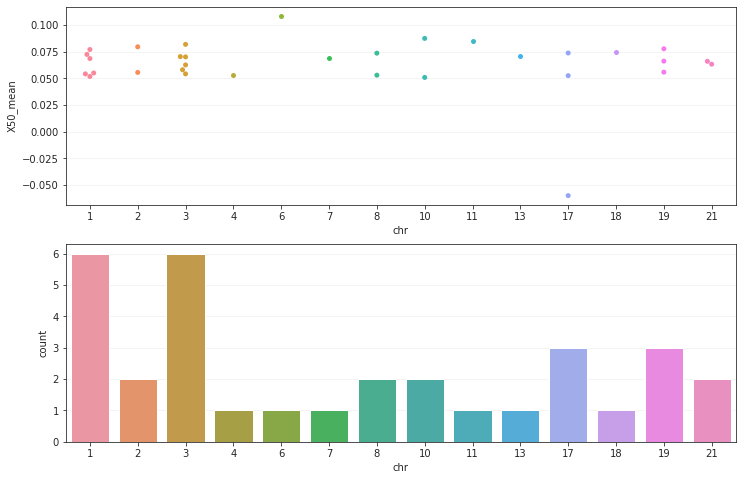

In [25]:
fig = plt.figure(figsize=(12,8))
plt.subplot(211)
# sns.stripplot(x="chr", y="X50_mean", data=selection, jitter=0.15)
sns.swarmplot(x="chr", y="X50_mean", data=selection)
plt.subplot(212)
# sns.barplot(x="chr", y="X50_mean", data=selection)
sns.countplot(x="chr", data=selection)

## Análise por sexo

In [26]:
# feature importance - M x F
# age: 50, set: test

In [27]:
feat_imp_M50 = feat_importance(e_train, 50, 'M')
feat_imp_F50 = feat_importance(e_train, 50, 'F')

In [28]:
tmp = feat_imp_M50.join(feat_imp_F50, how='inner')
tmp

,M50_mean,M50_median,F50_mean,F50_median
snp_8_133462953,0.018710,0.001876,0.017783,0.001869
snp_2_91635413,0.009707,0.002707,0.010127,0.002784
snp_9_25963828,0.003942,0.002956,0.004738,0.003474
snp_1_17764169,0.001198,0.000232,0.001289,0.000243
snp_12_41767967,-0.001209,-0.000216,-0.001198,-0.000349
...,...,...,...,...
snp_20_26104019,0.001945,0.000465,0.002055,0.000579
snp_20_50189624,-0.007031,-0.005132,-0.007918,-0.005674
snp_1_143276644,-0.001762,-0.000437,-0.002267,-0.000691
snp_16_9536673,-0.003562,-0.000446,-0.003917,-0.000577


In [29]:
# tmp.sort_values(by="M50_mean").to_csv("feature_importance_sex.csv")

(-0.2, 0.35)

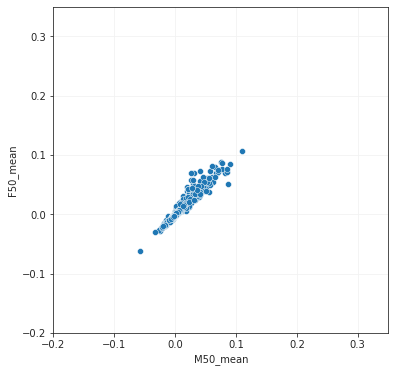

In [30]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x="M50_mean", y="F50_mean", data=tmp)
plt.ylim(-0.2,0.35)
plt.xlim(-0.2,0.35)

(-0.2, 0.35)

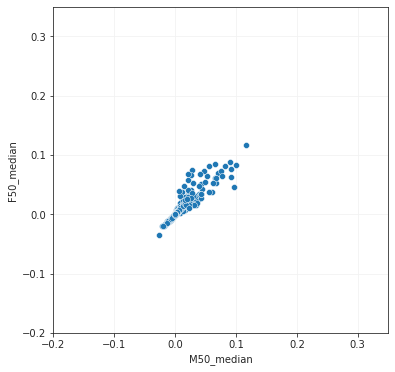

In [31]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x="M50_median", y="F50_median", data=tmp)
plt.ylim(-0.2,0.35)
plt.xlim(-0.2,0.35)

In [32]:
tmp.sort_values(by="F50_mean").tail(20)

,M50_mean,M50_median,F50_mean,F50_median
snp_1_83758864,0.067551,0.066572,0.068945,0.053098
snp_13_74682115,0.031358,0.021617,0.069032,0.067775
snp_7_76792320,0.068580,0.048487,0.069766,0.053737
snp_21_18746599,0.025562,0.020581,0.070028,0.058262
snp_1_209147965,0.081823,0.091971,0.070071,0.062450
snp_3_5574766,0.070212,0.066961,0.070476,0.061275
snp_3_75343128,0.068404,0.075268,0.070588,0.073366
snp_19_34109339,0.085133,0.092317,0.071312,0.076783
snp_17_72720155,0.040856,0.028246,0.072921,0.074790
snp_13_26574243,0.057851,0.052617,0.073751,0.065099


In [33]:
tmp = feat_imp_M50.join(feat_imp_F50, how='inner')
tmp = tmp[abs((tmp['M50_mean']+tmp['F50_mean']))/2 > 0.05]
tmp['SNP'] = tmp.index
# parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
tmp.sort_values(by="M50_mean")

,M50_mean,M50_median,F50_mean,F50_median,SNP
snp_17_15464147,-0.056857,-0.026306,-0.062443,-0.034941,snp_17_15464147
snp_13_74682115,0.031358,0.021617,0.069032,0.067775,snp_13_74682115
snp_17_72720155,0.040856,0.028246,0.072921,0.074790,snp_17_72720155
snp_10_116532517,0.045882,0.025559,0.063169,0.066255,snp_10_116532517
snp_1_10895904,0.047753,0.029480,0.054889,0.053557,snp_1_10895904
snp_1_26921907,0.048697,0.041031,0.055789,0.032095,snp_1_26921907
snp_1_28174526,0.050562,0.044336,0.056836,0.042167,snp_1_28174526
snp_19_19365233,0.052311,0.042642,0.060906,0.051545,snp_19_19365233
snp_3_75105173,0.053072,0.042769,0.054549,0.034708,snp_3_75105173
snp_8_37417160,0.054878,0.031075,0.052771,0.015056,snp_8_37417160


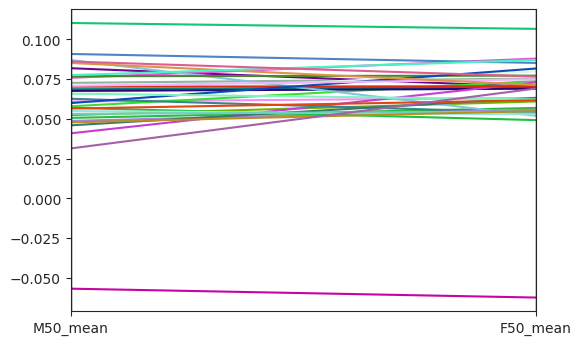

In [34]:
fig = plt.figure(dpi=100)
parallel_coordinates(tmp, 'SNP', cols=['M50_mean', 'F50_mean'] ).legend().remove() 

In [35]:
# feature importance - lifelong variability

In [36]:
feat_imp_by_age = feat_importance(e_test, 20, 'X') 
for age in range(30, 90, 10):
    feat_imp_by_age = feat_imp_by_age.join(feat_importance(e_test, age, 'X'),how='inner')

<ipython-input-37-09a6d1fa94fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['SNP'] = tmp.index


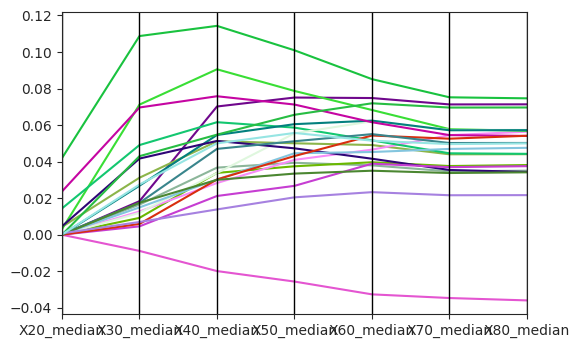

In [37]:
tmp = feat_imp_by_age[abs(feat_imp_by_age['X80_mean']) > 0.04]
tmp['SNP'] = tmp.index
fig = plt.figure(dpi=100)
parallel_coordinates(tmp, 'SNP', cols=[i for i in feat_imp_by_age.columns if 'median' in i]).legend().remove() 

In [38]:
tmp = feat_imp_M50.join(feat_imp_F50, how='inner')
tmp = tmp[abs((tmp['M50_mean']+tmp['F50_mean']))/2 > 0.04]
tmp['SNP'] = tmp.index
# parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
tmp.sort_values(by="M50_mean")

,M50_mean,M50_median,F50_mean,F50_median,SNP
snp_17_15464147,-0.056857,-0.026306,-0.062443,-0.034941,snp_17_15464147
snp_21_18746599,0.025562,0.020581,0.070028,0.058262,snp_21_18746599
snp_18_21655669,0.026644,0.015288,0.058611,0.047563,snp_18_21655669
snp_19_32504936,0.029346,0.015857,0.050775,0.022791,snp_19_32504936
snp_6_170653258,0.029731,0.007259,0.057492,0.030391,snp_6_170653258
snp_13_74682115,0.031358,0.021617,0.069032,0.067775,snp_13_74682115
snp_16_62783842,0.037829,0.022741,0.047653,0.015329,snp_16_62783842
snp_11_61778091,0.037918,0.028209,0.044468,0.035847,snp_11_61778091
snp_5_71064155,0.039798,0.033482,0.043723,0.031157,snp_5_71064155
snp_15_44861299,0.040468,0.022276,0.043053,0.029687,snp_15_44861299


<AxesSubplot:>

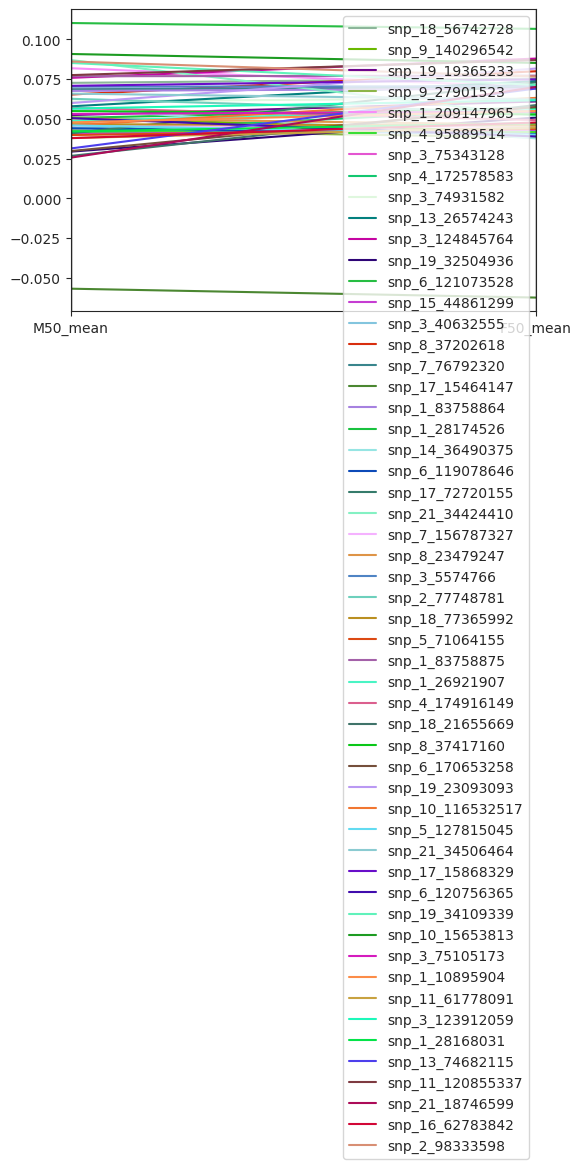

In [39]:
fig = plt.figure(dpi=100)
parallel_coordinates(tmp, 'SNP', cols=['M50_mean', 'F50_mean'])

In [40]:
feat_imp_by_age = feat_importance(e_test, 20, 'X') 
for age in range(30, 90, 10):
    feat_imp_by_age = feat_imp_by_age.join(feat_importance(e_test, age, 'X'),how='inner')
    

In [41]:
[i for i in feat_imp_by_age.columns if 'mean' in i]

['X20_mean',
 'X30_mean',
 'X40_mean',
 'X50_mean',
 'X60_mean',
 'X70_mean',
 'X80_mean']

<ipython-input-42-3a6845a477e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['SNP'] = tmp.index


<AxesSubplot:>

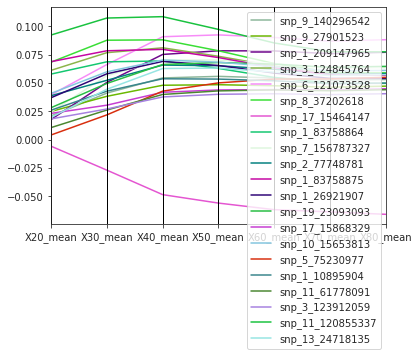

In [42]:
tmp = feat_imp_by_age[abs(feat_imp_by_age['X80_mean']) > 0.04]
tmp['SNP'] = tmp.index
parallel_coordinates(tmp, 'SNP', cols=[i for i in feat_imp_by_age.columns if 'mean' in i])

<AxesSubplot:>

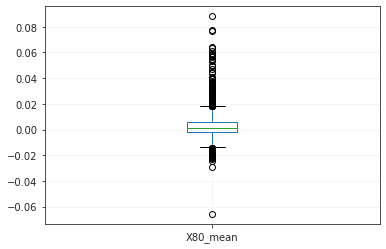

In [91]:
feat_imp_by_age[['X80_mean']].boxplot()

In [92]:
feat_imp_M50.sort_values(by=0, ascending=False).head(50)

KeyError: 0

In [ ]:
imp = e_test.calc_attr(20, 'X', samples_per_model=1)

In [ ]:
s

In [ ]:
dfnew.sort_values(by=0, ascending=True).head(50)

In [ ]:
import pandas as pd
dfnew = pd.DataFrame.from_dict(s, orient='index')
dfnew.sort_values(by=0, ascending=False).head(50)

In [ ]:
import pandas as pd
dfnew = pd.DataFrame.from_dict(s, orient='index')
dfnew.sort_values(by=0, ascending=False).head(50)

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(s, orient='index')

In [ ]:
df.sort_values(by=0, ascending=True).head(50)

In [ ]:
df.sort_values(by=0, ascending=True).head(50)

In [ ]:
import numpy as np
np.mean(df.values, axis=0)

In [ ]:
df_20_X = e_train.attr_snps_mean(attrs, mask).rename(columns={0: "age=20,sex=X"})

In [ ]:
df_20_X.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
attr, mask = e_train.calc_attr(20, 'X', samples=1)
df_20_X = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=X"})
attr, mask = e_train.calc_attr(20, 'M', samples=1)
df_20_M = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=M"})
attr, mask = e_train.calc_attr(20, 'F', samples=1)
df_20_F = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=F"})

In [ ]:
df_decay2 = df_20_X.sort_values(by="age=20,sex=X", ascending=False)
df_decay2.head(20)

In [ ]:
df_decay1 = df_20_X.sort_values(by="age=20,sex=X", ascending=False)
df_decay1.head(20)

In [ ]:
df_train[df_train.index=='snp_4_172986805']

In [ ]:
attr, mask = e_train.calc_attr(50, 'X', samples=1)
df_50_X = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=X"})
attr, mask = e_train.calc_attr(50, 'M', samples=1)
df_50_M = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=M"})
attr, mask = e_train.calc_attr(50, 'F', samples=1)
df_50_F = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=F"})

In [ ]:
df_train = df_20_X.join([df_20_F,df_20_M,df_50_X,df_50_F,df_50_M])

In [ ]:
df_train.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
df_train.sort_values(by="age=50,sex=X", ascending=False).tail(50)

In [ ]:
plt.boxplot(df_20_X.values)

In [ ]:
attr, mask = e_test.calc_attr(20, 'X', samples=1)
df_20_X_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=X"})
attr, mask = e_test.calc_attr(20, 'M', samples=1)
df_20_M_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=M"})
attr, mask = e_test.calc_attr(20, 'F', samples=1)
df_20_F_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=F"})

In [ ]:
attr, mask = e_test.calc_attr(50, 'X', samples=1)
df_50_X_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=X"})
attr, mask = e_test.calc_attr(50, 'M', samples=1)
df_50_M_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=M"})
attr, mask = e_test.calc_attr(50, 'F', samples=1)
df_50_F_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=F"})

In [ ]:
df_test = df_20_X_test.join([df_20_F_test,df_20_M_test,df_50_X_test,df_50_F_test,df_50_M_test])

In [ ]:
df_test.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
df_test.sort_values(by="age=20,sex=X", ascending=False).tail(50)

In [ ]:
df = df_train.join(df_test, lsuffix='_train', rsuffix='_test')

In [ ]:
sns.pairplot(df.sort_values(by="age=20,sex=X_train", ascending=False).head(20))
# plt.savefig('pairplot.svg')

In [ ]:
df.sort_values(by="age=20,sex=X_train", ascending=False).head(20)

In [ ]:
df_sel = df.reindex(df["age=20,sex=X_train"].abs().sort_values(ascending=False).index).head(100)

In [ ]:
df_sel

In [ ]:
tmp = dict(Counter([s[:s.index('_',4)] for s in list(df_sel.index)]))
sns.barplot(x=list(tmp.keys()), y=list(tmp.values()))

In [ ]:
df_not_sel = df.reindex(df["age=20,sex=X_train"].abs().sort_values(ascending=False).index).tail(500)

In [ ]:
Counter([s[:s.index('_',4)] for s in list(df_not_sel.index)])

In [ ]:
list(tmp.values())

In [ ]:
plt.subplot(141)
plt.title("Precision")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.subplot(142)
plt.title("Recall")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.yticks([])
plt.subplot(143)
plt.title("F1-Score")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.yticks([])
plt.subplot(144)
plt.title("Frequency")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
plt.xscale('log')
plt.yticks([])

In [ ]:
feat_imp_M50.sort_values(by='M50_mean')

In [ ]:
feat_imp_M50.sort_values(by='M50_mean')

In [ ]:
plt.boxplot(feat_imp_M50['M50_mean'])

In [ ]:
df_test = pd.read_csv("../datasets/visits_sp_unique_test_positivo_1000_random_0.csv")

In [ ]:
df_train = pd.read_csv("../datasets/visits_sp_unique_train_positivo_1000_random_0.csv")

In [ ]:
c1 = df_test.columns
c2 = df_train.columns
for i in range(1009):
    if c1[i] != c2[i]:
        print(f"{c1[i]} = {c2[i]}")
    

In [ ]:
a = np.arange(-10,10)

In [ ]:
a

In [ ]:
plt.scatter(x=1,y=a)